In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux
import matplotlib as mpl
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'

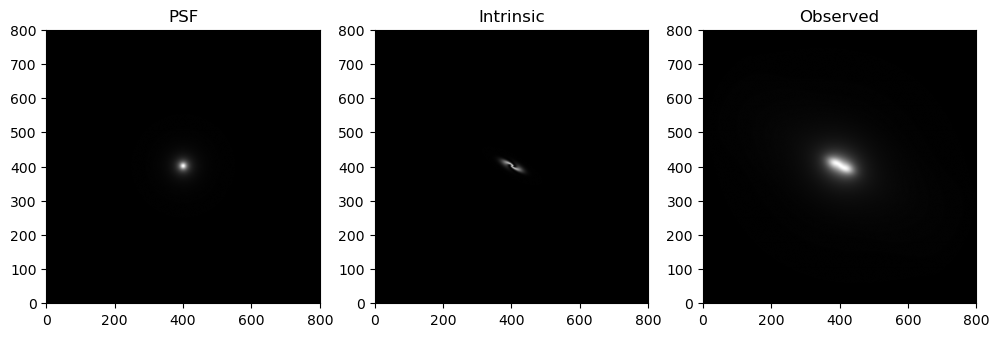

In [5]:
width = 800
height = 800

# Create PSF and Galaxy images
image_psf = moffat(width, height, 1, 10)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [6]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 20, 20)
weight_low_res = gaussian_weight(height//2, width//2, height / 4, width / 4, 10, 10)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, sigma_F = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')

The aperture flux measured using the intrinsic image and weight function : 0.252185
The aperture flux using the observed image and rescaled weight function : 0.252173


In [ ]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift

def estimate_sigma(noise_image, weight, maxlag):
    local_covariance = covariance_fft2d(noise_image, maxlag)
    variance = weighted_variance_lag(weight, local_covariance, maxlag)
    return np.sqrt(variance)

def covariance_fft2d(image, maxlag):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)
    
    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)

    cy, cx = h//2, w//2
    window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
    return window



def weighted_variance_lag(s, C_local, max_lag):
    H, W = s.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = s[y0:y1, x0:x1]
            s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

In [8]:
# np.random.seed(0)
n = 256
true_sigma = 0.01
noise = np.random.normal(0, true_sigma, (n, n))

C = covariance_fft2d(noise, maxlag=10)
print("FFT variance:", C[C.shape[0]//2, C.shape[1]//2], true_sigma**2)  # ≈ true_sigma²

s = np.ones((n, n))
V_pred = weighted_variance_lag(s, C, max_lag=10)
V_sim = np.var(noise * s)
print("Predicted σ:", np.sqrt(V_pred))
print("Simulated σ:", np.sqrt(V_sim))


FFT variance: 0.00010066254667952571 0.0001
Predicted σ: 2.5736768939593775
Simulated σ: 0.01003307264398727


In [9]:
weight_new = wiener_deconvolution(weight, image_psf)
weight_new /= np.sum(weight_new)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:20<00:00,  2.10s/it]


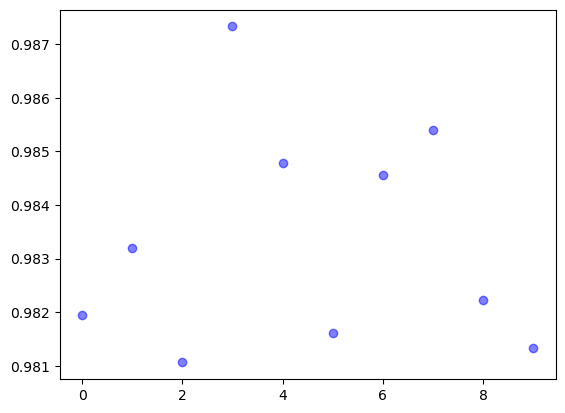

0.0009678091082489191 0.0011781292703233674


In [26]:
n_iterations = 10
flux = np.zeros(n_iterations)
sigma = np.zeros(n_iterations)
noise_psf = moffat(width, height, 10, 3)
maxlag = 20
for i in tqdm(range(n_iterations)):
    noise = np.random.normal(0, .1, (height, width))
    noise = fftconvolve(noise, noise_psf, mode="same") 
    noisy_image = image+noise
    flux[i], hi = calculate_gaap_flux(noisy_image, image_psf, weight, [(height / 2, width / 2)])
    sigma[i] = estimate_sigma(noise, weight_new, maxlag)

    plt.scatter(i, hi/estimate_sigma(noise, weight_new, 0), color='blue', alpha=0.5)
plt.show()
print(np.std(flux), np.nanmean(sigma))


In [11]:
import numpy as np
from scipy.ndimage import uniform_filter

def find_noise_square(image, box_size=50, margin=3):
    """
    Automatically find a square region with low signal (noise-dominated).
    image: 2D array
    box_size: side of the square region (pixels)
    margin: exclude edges
    threshold: how many sigma above the median to consider as "source"
    returns: (y0, x0, y1, x1) slice indices of best noise square
    """
    img = np.asarray(image, float)
    h, w = img.shape

    # smooth absolute value to find low-variance zones
    local_mean = uniform_filter(img, size=box_size)
    local_var = uniform_filter(img**2, size=box_size) - local_mean**2
    local_std = np.sqrt(np.maximum(local_var, 0))

    # exclude borders
    local_std[:margin, :] = np.inf
    local_std[-margin:, :] = np.inf
    local_std[:, :margin] = np.inf
    local_std[:, -margin:] = np.inf

    # pick minimum std region (least structured)
    cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

    # ensure square fits inside image
    half = box_size // 2
    y0 = max(0, cy - half)
    x0 = max(0, cx - half)
    y1 = min(h, y0 + box_size)
    x1 = min(w, x0 + box_size)

    return y0, x0, y1, x1


In [12]:
from scipy.ndimage import map_coordinates
def calculate_gaap_flux(image, psf, weight, centers):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale = wiener_deconvolution(weight, psf, 0)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0]

    valid = np.isfinite(xs) & np.isfinite(ys)
    measured_F = np.full(len(centers), np.nan, dtype=np.float32)
    measured_F[valid] = map_coordinates(flux_map, [ys[valid], xs[valid]], order=1)

    x_negative = image[image<0].flatten()
    sigma = np.sqrt(np.sum(x_negative ** 2) * np.sum(weight_rescale ** 2) / len(x_negative))

    return measured_F, weight_rescale

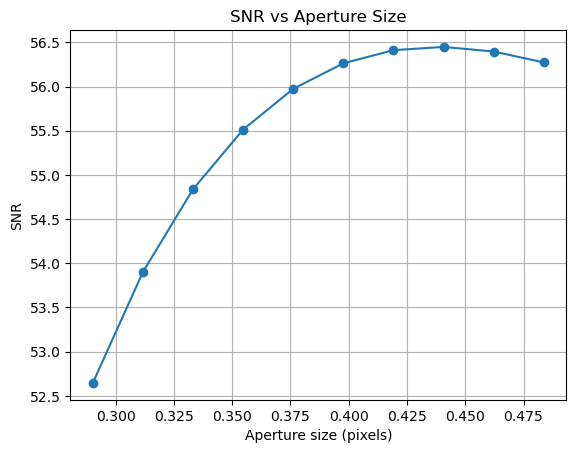

In [13]:
sizes = np.linspace(30, 50, 10)
noise = np.random.normal(0, .1, (height, width))
noise_psf = moffat(width, height, 10, 2)
noise = fftconvolve(noise, noise_psf, mode="same")
noisy_image = image+noise
snr = np.zeros_like(sizes)
for i, size in enumerate(sizes):
    weight = gaussian_weight(height, width, height / 2, width / 2, size, size)
    flux, weight_new = calculate_gaap_flux(noisy_image, image_psf, weight, [(height / 2, width / 2)])
    sigma = estimate_sigma(noise, weight_new, maxlag)
    snr[i] = flux / sigma
plt.plot(sizes/103.374441869144, snr, marker='o')
plt.xlabel("Aperture size (pixels)")
plt.ylabel("SNR")
plt.title("SNR vs Aperture Size")
plt.grid()
plt.show()

In [14]:
from numpy.fft import fft2, ifft2, fftshift

def optimal_w_fft2d(S, cov_patch):
    """
    Compute w* = C^-1 S using FFT convolution (avoids forming full matrix)
    S: 2D image (residual)
    cov_patch: 2D covariance kernel (from covariance_fft2d)
    Returns: w_opt (2D array same shape as S)
    """
    # FFT of image and covariance patch
    H, W = S.shape
    # pad covariance patch to image size
    cov_padded = np.zeros_like(S)
    h, w = cov_patch.shape
    cy, cx = h//2, w//2
    cov_padded[:h, :w] = cov_patch
    cov_padded = np.roll(cov_padded, shift=(-cy, -cx), axis=(0,1))  # center at (0,0)

    S_fft = fft2(S)
    C_fft = fft2(cov_padded)
    
    # Solve in Fourier domain (C w = S => w = IFFT(FFT(S)/FFT(C)))
    w_fft = S_fft / (C_fft)  # add small epsilon to avoid division by zero
    w_opt = np.real(ifft2(w_fft))
    
    # normalize
    w_opt /= np.linalg.norm(w_opt)
    
    return w_opt


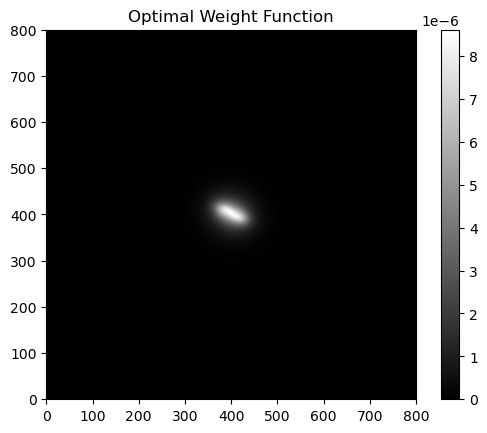

In [15]:
noise = np.random.normal(0, .01, (height, width))
noise_psf = moffat(width, height, 10, 1)
noise = fftconvolve(noise, noise_psf, mode="same")
# optimal_weight = optimal_w_fft2d(image+noise, covariance_fft2d(noise, maxlag=10))
plt.imshow(image*gaussian_weight(height, width, height / 2, width / 2, 50, 50), extent=(0, width, 0, height))
plt.title("Optimal Weight Function")
plt.colorbar()
plt.show()

In [16]:
from scipy.optimize import curve_fit
def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, offset):
    x, y = xy
    g = offset + amplitude * np.exp(
        -(((x - x0)**2)/(2*sigma_x**2) + ((y - y0)**2)/(2*sigma_y**2))
    )
    return g.ravel()


In [17]:
y = np.arange(image.shape[0])
x = np.arange(image.shape[1])
x, y = np.meshgrid(x, y)

# Flatten image and coordinates
xdata = np.vstack((x.ravel(), y.ravel()))
ydata = image.ravel()

amplitude_guess = np.max(image)
x0_guess = np.argmax(np.sum(image, axis=0))
y0_guess = np.argmax(np.sum(image, axis=1))
sigma_x_guess = image.shape[1]/4
sigma_y_guess = image.shape[0]/4
offset_guess = np.min(image)

initial_guess = [amplitude_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess, offset_guess]

popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)

amplitude, x0, y0, sigma_x, sigma_y, offset = popt
fwhm_x = 2 * np.sqrt(2 * np.log(2)) * sigma_x
fwhm_y = 2 * np.sqrt(2 * np.log(2)) * sigma_y
print(x0, y0)
print(f"FWHM X: {fwhm_x:.2f} pixels")
print(f"FWHM Y: {fwhm_y:.2f} pixels")
print(np.sqrt(fwhm_x ** 2 + fwhm_y ** 2))

400.99928469895826 400.9998534600713
FWHM X: -83.15 pixels
FWHM Y: 61.41 pixels
103.374441869144
